In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pytz as tz
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

In [48]:
df = pd.read_csv('Gowalla_totalCheckins.txt', sep='\t', header=None)
df.columns = ['userid','timestamp','latitude','longitude','spotid']
df.head()

,userid,timestamp,latitude,longitude,spotid
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6442892 entries, 0 to 6442891
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userid     int64  
 1   timestamp  object 
 2   latitude   float64
 3   longitude  float64
 4   spotid     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 245.8+ MB


In [5]:
#df.isnull().sum()

In [49]:
lon_min, lat_min, lon_max, lat_max = -74.2589, 40.4774, -73.7004, 40.9176
nyc_events = df[(df['longitude']>lon_min) & 
           (df['longitude']<lon_max) & 
           (df['latitude']>lat_min) & 
           (df['latitude']<lat_max)]
nyc_events.head()

,userid,timestamp,latitude,longitude,spotid
10,0,2010-10-12T00:21:28Z,40.643885,-73.782806,23261
11,0,2010-10-11T20:21:20Z,40.741374,-73.988105,16907
12,0,2010-10-11T20:20:42Z,40.741388,-73.989455,12973
13,0,2010-10-11T00:06:30Z,40.724910,-73.994621,341255
14,0,2010-10-10T22:00:37Z,40.729768,-73.998535,260957


In [50]:
nyc_events.shape

(138957, 5)

In [51]:
print(nyc_events.iloc[0:,4])

10          23261
11          16907
12          12973
13         341255
14         260957
            ...  
6441849     12313
6442621     23741
6442622     12535
6442623     11857
6442624     99459
Name: spotid, Length: 138957, dtype: int64


In [52]:
venues = pd.read_csv('spots.txt', sep='\t', header=0)
venues.head()

,spotid,spotname,geo-coordinates
0,1391604,Conference House Park,POINT(-74.2523431778 40.5017589436)
1,1391611,Almer G. Russell Pavilion,POINT(-74.2542636395 40.5022647413)
2,3612422,Conference House,POINT(-74.2490418254 40.5000644614)
3,3612431,Billop House,POINT(-74.2490418254 40.5000644614)
4,1391499,Biddle House,POINT(-74.2541456223 40.5054829933)


In [53]:
import pytz as tz
from datetime import datetime

In [54]:
def parse_datetime(s):
    tzone = tz.timezone("America/New_York") #parse_datetime
    utc = datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')
    return tz.utc.localize(utc).astimezone(tzone)

In [55]:
nyc_events.iloc[:, 1 : 2]

,timestamp
10,2010-10-12T00:21:28Z
11,2010-10-11T20:21:20Z
12,2010-10-11T20:20:42Z
13,2010-10-11T00:06:30Z
14,2010-10-10T22:00:37Z
...,...
6441849,2010-08-14T19:56:43Z
6442621,2010-09-29T22:57:13Z
6442622,2010-09-29T22:56:47Z
6442623,2010-09-29T18:49:51Z


In [56]:
nyc_events['ts'] = nyc_events['timestamp'].apply(lambda x: parse_datetime(x))
nyc_events = nyc_events.drop('timestamp',axis=1,errors='ignore')

#local date and time
nyc_events['date']  = nyc_events['ts'].astype(object).apply(lambda x : x.date())
nyc_events['time']  = nyc_events['ts'].astype(object).apply(lambda x : x.time())

#day of the week (localtime)
#hour of the day (localtime)
nyc_events['weekday']  = nyc_events['date'].astype(object).apply(lambda x : x.weekday())
nyc_events['day']   = nyc_events['date'].astype(object).apply(lambda x : x.day)
nyc_events['hour']   = nyc_events['time'].astype(object).apply(lambda x : x.hour)

nyc_events[['ts','date','time','weekday','day','hour']][0:5]

<ipython-input-56-3cac15c461ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_events['ts'] = nyc_events['timestamp'].apply(lambda x: parse_datetime(x))


,ts,date,time,weekday,day,hour
10,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16
13,2010-10-10 20:06:30-04:00,2010-10-10,20:06:30,6,10,20
14,2010-10-10 18:00:37-04:00,2010-10-10,18:00:37,6,10,18


In [57]:
nyc_events.head(10)

,userid,latitude,longitude,spotid,ts,date,time,weekday,day,hour
10,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20
11,0,40.741374,-73.988105,16907,2010-10-11 16:21:20-04:00,2010-10-11,16:21:20,0,11,16
12,0,40.741388,-73.989455,12973,2010-10-11 16:20:42-04:00,2010-10-11,16:20:42,0,11,16
13,0,40.724910,-73.994621,341255,2010-10-10 20:06:30-04:00,2010-10-10,20:06:30,6,10,20
14,0,40.729768,-73.998535,260957,2010-10-10 18:00:37-04:00,2010-10-10,18:00:37,6,10,18
15,0,40.728527,-73.996868,1933724,2010-10-10 17:17:14-04:00,2010-10-10,17:17:14,6,10,17
16,0,40.741747,-73.993421,105068,2010-10-10 13:47:04-04:00,2010-10-10,13:47:04,6,10,13
17,0,40.734193,-74.004164,34817,2010-10-09 19:51:10-04:00,2010-10-09,19:51:10,5,9,19
18,0,40.742512,-74.006031,27836,2010-10-09 18:27:07-04:00,2010-10-09,18:27:07,5,9,18
19,0,40.742396,-74.007543,15079,2010-10-09 17:39:26-04:00,2010-10-09,17:39:26,5,9,17


In [58]:
nyc_events = pd.DataFrame.merge(nyc_events, venues[['spotid','spotname']], on='spotid', how="inner")
nyc_events.head()

,userid,latitude,longitude,spotid,ts,date,time,weekday,day,hour,spotname
0,0,40.643885,-73.782806,23261,2010-10-11 20:21:28-04:00,2010-10-11,20:21:28,0,11,20,JFK John F. Kennedy International
1,0,40.643885,-73.782806,23261,2010-10-07 11:27:40-04:00,2010-10-07,11:27:40,3,7,11,JFK John F. Kennedy International
2,5,40.643885,-73.782806,23261,2010-08-15 23:47:20-04:00,2010-08-15,23:47:20,6,15,23,JFK John F. Kennedy International
3,8,40.643885,-73.782806,23261,2010-10-06 16:23:14-04:00,2010-10-06,16:23:14,2,6,16,JFK John F. Kennedy International
4,15,40.643885,-73.782806,23261,2010-10-13 00:10:36-04:00,2010-10-13,00:10:36,2,13,0,JFK John F. Kennedy International


In [16]:
len(nyc_events.spotid.unique())

17291

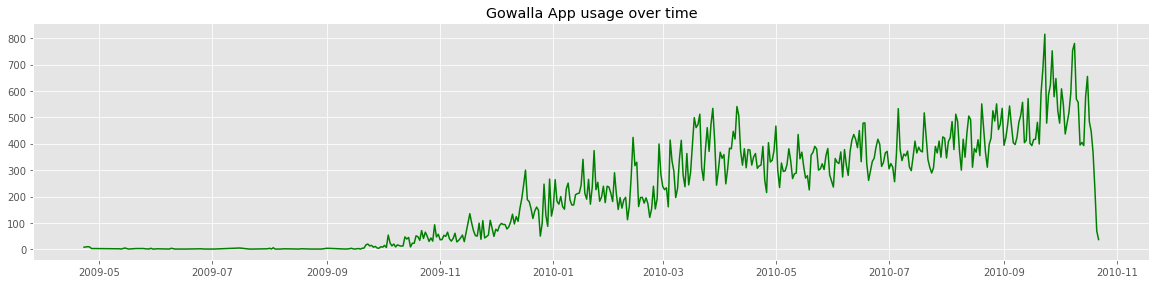

In [17]:
# Let us plot the events registered, ordered temporally by increasing timestamps and grouped by date
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 12})

plt.style.use('ggplot')

plt.subplot(4, 1, 1)
top = nyc_events.groupby('date').size()
plt.plot(top.index, top, 'g-')
plt.title('Gowalla App usage over time')
plt.show()


Text(0.5, 1.0, 'Check-ins: Hour of the day')

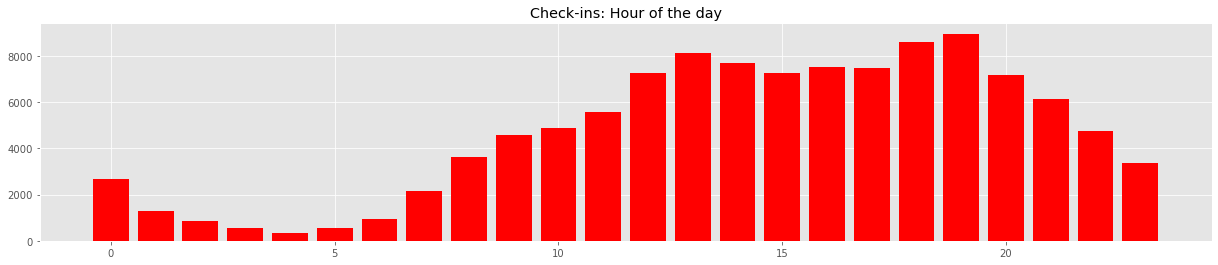

In [18]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)
top = nyc_events.groupby('hour').size()
plt.bar(top.index, top,align='center', color='red')
plt.title('Check-ins: Hour of the day')

Text(0.5, 1.0, 'Check-ins: Day of the week')

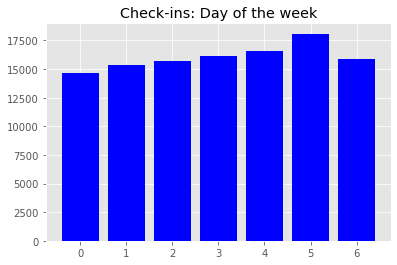

In [19]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)
plt.subplot(1, 3, 2)
top = nyc_events.groupby('weekday').size()
plt.bar(top.index, top,align='center',color='blue')
plt.title('Check-ins: Day of the week')

Text(0.5, 1.0, 'Check-ins: Day of the month')

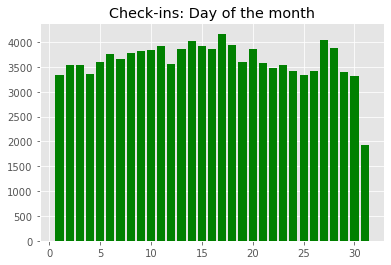

In [20]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)
plt.subplot(1, 3, 3)
top = nyc_events.groupby('day').size()
plt.bar(top.index, top,align='center',color='green')
plt.title('Check-ins: Day of the month')

In [21]:
kmeans=KMeans(n_clusters=240, init='k-means++')

In [22]:
kmeans = KMeans(n_clusters=240, init='k-means++')

# Compute the clusters based on longitude and latitude features
X_sample = nyc_events[['longitude','latitude']].sample(frac=0.1)
kmeans.fit(X_sample)
y = kmeans.labels_
print("k = 240", " silhouette_score ", silhouette_score(X_sample, y, metric='euclidean'))

k = 240  silhouette_score  0.4680392378843538


In [23]:
nyc_events['cluster'] = kmeans.predict(nyc_events[['longitude','latitude']])
nyc_events[['userid','latitude','longitude','spotid','cluster']].sample(10)

,userid,latitude,longitude,spotid,cluster
19883,114899,40.734039,-73.990699,22168,41
25998,5479,40.756498,-73.973469,37286,32
31635,6156,40.759281,-73.980635,27719,131
75755,2105,40.741119,-74.001572,93197,184
42681,88599,40.727703,-73.985192,99647,61
56299,3011,40.764310,-73.963309,3392982,104
91574,27616,40.724068,-73.993874,4040422,13
18873,13116,40.711435,-74.012189,11797,154
33101,127022,40.807313,-73.962514,37749,36
24265,3625,40.741504,-73.985275,48762,4


In [24]:
nyc_events['cluster'].unique()

array([101, 223,  13,  68, 114, 214,  25,  61,  10,  98, 151,  99,  77,
       200, 170, 226,  22, 103,  58, 122,  86, 202,  84, 227, 175, 225,
       126, 165, 196, 132, 147, 182, 210, 189,  29, 178, 131, 117,   2,
       220,  74, 138,  32, 213, 176,  41,   5, 104,  51,   1, 144, 119,
        64, 238, 164,  30, 163, 171,   4, 130, 204, 166, 192, 154, 203,
       109, 193, 121, 208, 188, 219, 108, 145,  48, 207, 156, 184,  81,
        44,  49, 179,   8,  80,  91, 216, 215,  36, 155,  24,  70, 118,
        90, 133, 141,  59,  28,  27,  87, 105,  42,   9,  92,  73, 237,
        34, 197,   6, 123, 217, 100,  76, 161, 233,  93, 211,  71,  12,
       235,  14, 159, 112, 186,  33,  47, 185, 195,  23,  85,   7, 212,
       209, 143, 231, 102, 146, 149,  95, 111,  69, 148, 137,   0,  19,
        75,  67, 134, 199,  21, 168,  55, 110,  50, 150, 135, 153, 222,
       107, 139,  38, 201, 191,  53,  66, 120,  45, 228,  56, 172, 125,
       205, 230, 113,  20, 142,  62, 162,  63,  94,  18, 229,  3

In [25]:
gdf = nyc_events.groupby(['cluster', 'spotid']).size().reset_index()
gdf.columns = ['cluster', 'spotid', 'count']
idx = gdf.groupby(['cluster'])['count'].transform(max) == gdf['count']
topvenues_df = gdf[idx].merge(venues, on='spotid', how='left').sort_values(by='count', ascending=False)
#top 10 out of 200 clusters by events count
topvenues = topvenues_df[:10]

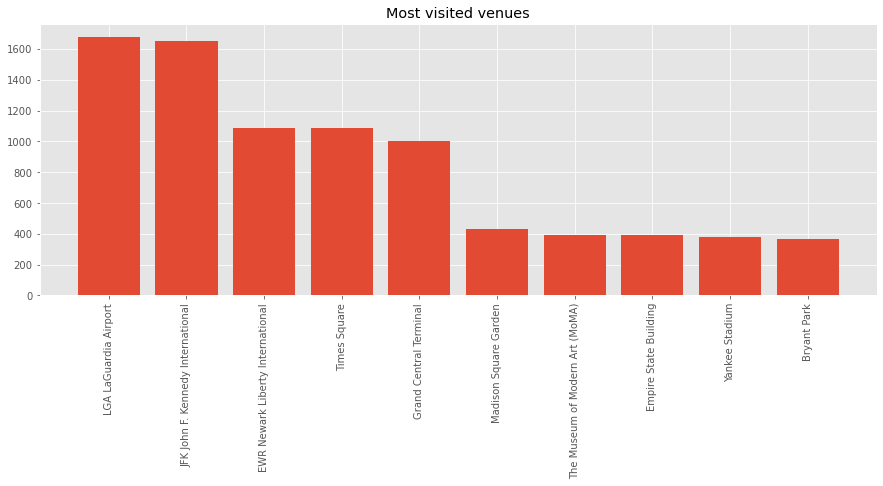

In [26]:
# Most Visited Venues
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,5)

plt.bar(range(len(topvenues)), topvenues['count'], align='center')
plt.xticks(range(len(topvenues)),topvenues['spotname'], rotation='vertical')
plt.title('Most visited venues')
plt.show()

In [27]:
def recommend_venues(df, longitude, latitude):
    predicted_cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    # Fetch the venue name of the top most record in the topvenues dataframe for the predicted cluster
    venue_name = df[df['cluster']==predicted_cluster].iloc[0]['spotname']
    msg = 'What about visiting the ' + venue_name + '?'
    return msg

In [28]:
recommend_venues(topvenues_df, -74, 40.55)

'What about visiting the Coney Island Boardwalk?'

In [29]:
recommend_venues(topvenues_df, -73.993, 40.75)

'What about visiting the Madison Square Garden?'

In [30]:
kmeans.predict([[-74, 40.55]])

array([45])

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import f1_score,precision_score,recall_score,precision_recall_curve,accuracy_score,classification_report,plot_precision_recall_curve

In [60]:
#df=nyc_events.drop(['ts','time','date','weekday','day','hour','spotname'], axis=1)
#df.head()

In [61]:
nyc_events.drop(['ts'],axis=1,inplace=True)

In [47]:
 X = nyc_events.drop(['spotid'],axis=1)
 y = nyc_events.spotid

In [34]:
X.head()

,userid,latitude,longitude,date,time,weekday,day,hour,spotname,cluster
0,0,40.643885,-73.782806,2010-10-11,20:21:28,0,11,20,JFK John F. Kennedy International,101
1,0,40.643885,-73.782806,2010-10-07,11:27:40,3,7,11,JFK John F. Kennedy International,101
2,5,40.643885,-73.782806,2010-08-15,23:47:20,6,15,23,JFK John F. Kennedy International,101
3,8,40.643885,-73.782806,2010-10-06,16:23:14,2,6,16,JFK John F. Kennedy International,101
4,15,40.643885,-73.782806,2010-10-13,00:10:36,2,13,0,JFK John F. Kennedy International,101


In [35]:
nyc_events.head()

,userid,latitude,longitude,spotid,date,time,weekday,day,hour,spotname,cluster
0,0,40.643885,-73.782806,23261,2010-10-11,20:21:28,0,11,20,JFK John F. Kennedy International,101
1,0,40.643885,-73.782806,23261,2010-10-07,11:27:40,3,7,11,JFK John F. Kennedy International,101
2,5,40.643885,-73.782806,23261,2010-08-15,23:47:20,6,15,23,JFK John F. Kennedy International,101
3,8,40.643885,-73.782806,23261,2010-10-06,16:23:14,2,6,16,JFK John F. Kennedy International,101
4,15,40.643885,-73.782806,23261,2010-10-13,00:10:36,2,13,0,JFK John F. Kennedy International,101


In [62]:
nyc_events.drop(['date','time'],axis=1,inplace=True)

In [63]:
nyc_events.head()

,userid,latitude,longitude,spotid,weekday,day,hour,spotname
0,0,40.643885,-73.782806,23261,0,11,20,JFK John F. Kennedy International
1,0,40.643885,-73.782806,23261,3,7,11,JFK John F. Kennedy International
2,5,40.643885,-73.782806,23261,6,15,23,JFK John F. Kennedy International
3,8,40.643885,-73.782806,23261,2,6,16,JFK John F. Kennedy International
4,15,40.643885,-73.782806,23261,2,13,0,JFK John F. Kennedy International


In [38]:
nyc_events["spotname"].unique()

array(['JFK John F. Kennedy International', 'Shake Shack',
       'Flatiron Building ', ..., "Coopy's Den", 'Counter', 'PHA'],
      dtype=object)

In [39]:
nyc_events["spotname"].nunique()

14459

In [69]:
nyc_events["spotid"].nunique()

17291

In [40]:
nyc_events["spotname"]=nyc_events["spotname"].astype("str")

In [64]:
#nyc_events = nyc_events.drop(['spotname'],axis=1)

In [65]:
nyc_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112390 entries, 0 to 112389
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userid     112390 non-null  int64  
 1   latitude   112390 non-null  float64
 2   longitude  112390 non-null  float64
 3   spotid     112390 non-null  int64  
 4   weekday    112390 non-null  int64  
 5   day        112390 non-null  int64  
 6   hour       112390 non-null  int64  
 7   spotname   112390 non-null  object 
dtypes: float64(2), int64(5), object(1)
memory usage: 7.7+ MB


In [66]:
nyc_events.iloc[:,-1]

0         JFK John F. Kennedy International
1         JFK John F. Kennedy International
2         JFK John F. Kennedy International
3         JFK John F. Kennedy International
4         JFK John F. Kennedy International
                        ...                
112385                           Quik Check
112386                          Coopy's Den
112387                          Coopy's Den
112388                              Counter
112389                                  PHA
Name: spotname, Length: 112390, dtype: object

In [67]:
nyc_events.head(-50)

,userid,latitude,longitude,spotid,weekday,day,hour,spotname
0,0,40.643885,-73.782806,23261,0,11,20,JFK John F. Kennedy International
1,0,40.643885,-73.782806,23261,3,7,11,JFK John F. Kennedy International
2,5,40.643885,-73.782806,23261,6,15,23,JFK John F. Kennedy International
3,8,40.643885,-73.782806,23261,2,6,16,JFK John F. Kennedy International
4,15,40.643885,-73.782806,23261,2,13,0,JFK John F. Kennedy International
...,...,...,...,...,...,...,...,...
112335,185595,40.832577,-74.158099,254283,1,22,18,Torino North
112336,186075,40.675973,-73.980904,1497213,0,18,11,Bob And Judi's Coolectibles
112337,186534,40.704507,-74.017268,1894639,0,16,13,New York Downtown Marriot International
112338,186629,40.775558,-73.950106,752329,2,30,13,Peters


In [68]:
print(nyc_events["spotid"]==1497213)

0         False
1         False
2         False
3         False
4         False
          ...  
112385    False
112386    False
112387    False
112388    False
112389    False
Name: spotid, Length: 112390, dtype: bool


In [125]:
print('There are {} uniques categories.'.format(len(nyc_events['spotname'].unique())))
nyc_events.groupby('spotname')['spotname'].count().sort_values(ascending=False)

There are 14459 uniques categories.


spotname
LGA LaGuardia Airport                1680
JFK John F. Kennedy International    1654
Starbucks                            1321
Starbucks Coffee                     1115
EWR Newark Liberty International     1089
                                     ... 
MMM Bello's Pub                         1
MLA                                     1
MET Foods                               1
MECHS2                                  1
Leo's Latticini                         1
Name: spotname, Length: 14459, dtype: int64

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [76]:
X = nyc_events.iloc[:,1:7]
y = nyc_events.iloc[:,7]

In [77]:
y

0         JFK John F. Kennedy International
1         JFK John F. Kennedy International
2         JFK John F. Kennedy International
3         JFK John F. Kennedy International
4         JFK John F. Kennedy International
                        ...                
112385                           Quik Check
112386                          Coopy's Den
112387                          Coopy's Den
112388                              Counter
112389                                  PHA
Name: spotname, Length: 112390, dtype: object

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=2)

In [116]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [117]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [118]:
knn.score(X_test, y_test)

0.7790728712518907

In [119]:
y_pred = knn.predict(X_test)

In [120]:
y_pred

array(['The Standard Grill', 'VaynerMedia HQ', 'Mario Pizza', ...,
       'Loreley Williamsburg', 'Terminal 1 at JFK',
       'Radio City Music Hall'], dtype=object)

In [122]:
X_test

,latitude,longitude,spotid,weekday,day,hour
42258,40.740795,-74.007736,144944,2,28,18
35189,40.723657,-74.008809,179980,2,1,8
97184,40.763373,-73.981698,479843,1,10,21
19781,40.735721,-73.989997,441925,6,11,17
60079,40.759317,-73.984377,926885,6,5,9
...,...,...,...,...,...,...
24382,40.715275,-74.010253,72882,3,9,12
36883,40.730576,-73.992437,444082,6,6,12
74174,40.747319,-73.985150,1256936,3,16,14
32688,40.643155,-73.789753,60201,0,28,23


In [123]:
y_test

42258           The Standard Grill
35189               VaynerMedia HQ
97184              Stage Star Deli
19781         Marquis De Lafayette
60079             Starbucks Coffee
                   ...            
24382                    Warren 77
36883    Eighth Street—NYU Station
74174                 Empire Pizza
32688            Terminal 1 at JFK
30863        Radio City Music Hall
Name: spotname, Length: 22478, dtype: object

In [124]:
accuracy_train = knn.score(X_train, y_train)
accuracy_test = knn.score(X_test, y_test)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

Score on training set: 0.8631439629860308
Score on test set: 0.7790728712518907


In [127]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [128]:
print(classification_report(y_test,knn.predict(X_test)))

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                       precision    recall  f1-score   support

                                                        $0.99 Express       1.00      1.00      1.00         1
                                                          $0.99 Pizza       0.00      0.00      0.00         1
                                                   'S' Building (MEC)       0.33      1.00      0.50         1
                                                             'inoteca       1.00      1.00      1.00         1
                                                               'sNice       1.00      1.00      1.00         6
                                                           'wichcraft       1.00      0.89      0.94        18
                                                          'wichcraft        0.00      0.00      0.00         1
                                        - USL - Union Square Lounge -       0.00      0.00      0.00         1


In [129]:
report = classification_report(y_test, y_pred, output_dict=True)

In [130]:
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
$0.99 Express,0.000000,0.000000,0.000000,1.000000
$0.99 Pizza,0.000000,0.000000,0.000000,1.000000
'S' Building (MEC),0.000000,0.000000,0.000000,1.000000
'Wichcraft,0.000000,0.000000,0.000000,0.000000
'inoteca,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...
Łomżynianka,0.000000,0.000000,0.000000,0.000000
"‘inoteca, liquori",0.000000,0.000000,0.000000,1.000000
accuracy,0.001201,0.001201,0.001201,0.001201
macro avg,0.000062,0.000045,0.000051,22478.000000


In [131]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(truth, pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return roc_auc_score(truth, pred, average=average)

In [ ]:
y_pred_proba = knn.predict_proba(X_test)

In [ ]:
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(f1_score(y_test, y_pred, average="macro"))
multiclass_roc_auc_score(y_test,y_pred,average="macro")

In [133]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=10,random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [134]:
dt.score(X_test, y_test)

MemoryError: Unable to allocate 2.27 GiB for an array with shape (22478, 1, 13561) and data type float64

In [ ]:
accuracy_train = dt.score(X_train, y_train)
accuracy_test = dt.score(X_test, y_test)
print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

In [ ]:
y_predict = dt.predict(X_test)

In [ ]:
y_predict

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
print(classification_report(y_test,dt.predict(X_test)))

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_predict,average="macro"))

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
GN = GaussianNB()
GN.fit(X_train, y_train)

In [ ]:
GN.score(X_test, y_test)

In [ ]:
accuracy_train = dt.score(X_train, y_train)
accuracy_test = dt.score(X_test, y_test)
print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
print(classification_report(y_test,dt.predict(X_test)))

In [ ]:
y_predict = GN.predict(X_test)

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_predict,average="macro"))

In [ ]:
from sklearn.linear_model import LogisticRegression
lr =  LogisticRegression()


lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [ ]:
accuracy_train = lr.score(X_train, y_train)
accuracy_test = lr.score(X_test, y_test)

print(f"Score on training set: {accuracy_train}")
print(f"Score on test set: {accuracy_test}")

In [ ]:
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

In [ ]:
predictions = lr.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
random_forest = RandomForestClassifier(max_depth=20, random_state=42)
random_forest.fit(X_train, y_train)

In [ ]:
random_forest.score(X_test, y_test)

In [ ]:
y_predict = random_forest.predict(X_test)
accuracy_score(y_test, y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

In [ ]:
predictions = random_forest.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

In [ ]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=2.0, solver='auto')
ridge.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = ridge.predict(X_test)
accuracy_score(y_test, y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
predictions = ridge.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
print(precision_score(y_test, y_predict, average="macro"))
print(recall_score(y_test, y_predict, average="macro"))
print(f1_score(y_test, y_predict, average="macro"))
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

In [ ]:
from sklearn.neural_network import MLPClassifier
neural = MLPClassifier(hidden_layer_sizes=(200, ), activation='logistic', alpha=0.001, learning_rate='adaptive')
neural.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = neural.predict(X_test)
accuracy_score(y_test, y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

In [ ]:
predictions = neural.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
predictions = neural.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
print(f1_score(y_test, predictions, average="macro"))
print(precision_score(y_test, predictions, average="macro"))
print(recall_score(y_test, predictions, average="macro")) 
print(multiclass_roc_auc_score(y_test,predictions,average="macro"))

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

In [ ]:
print("Classification Report")
print(classification_report(y_test, y_pred))

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))

In [ ]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [ ]:
encoder = OrdinalEncoder()
data_encoded = encoder.fit_transform(df4[f_name])
df_encoded = pd.DataFrame(data_encoded, columns=f_name)
encoder = LabelEncoder()
target_encoded = encoder.fit_transform(df4['venueCategory'])
df_encoded['venueCategory'] = target_encoded

In [ ]:
X=X.astype(float)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
encoded_Y

In [ ]:
dummies = pd.get_dummies(encoded_Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,encoded_Y, test_size=0.3, random_state=143)

In [ ]:
cnb = CategoricalNB()
cnb.fit(X_train, y_train)

In [ ]:
score=cnb.score(X_test, y_test)
score

In [ ]:
y_pred= cnb.predict(X_test)

In [ ]:
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro")) 
print(multiclass_roc_auc_score(y_test,y_pred,average="macro"))